In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [17]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


def plot_history(history):
    fig,axes = plt.subplots(1,2,figsize=(12,4))
    ax1,ax2 = axes.ravel()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    ax1.plot(epochs,acc,'b',label='Training')
    ax1.plot(epochs,val_acc,'r', label='Validation')
    ax1.set_xlabel('Epochs')
    #ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy')

    ax2.plot(epochs,loss,'b',label='Training')
    ax2.plot(epochs,val_loss,'r', label='Validation')
    ax2.set_xlabel('Epochs')
    #ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.legend()

embedding_dim = 100
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [6]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        text = row[5]
        label = int(row[0] != '0')
        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        corpus.append([text,label])


--2021-08-03 11:40:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  48.9MB/s    in 4.7s    

2021-08-03 11:40:58 (48.9 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [7]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [8]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating= trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
                            
test_labels = labels[:split]
training_labels = labels[split:]

test_sequences = np.array(test_sequences)
training_sequences = np.array(training_sequences)

test_labels = np.array(test_labels)
training_labels = np.array(training_labels)

In [9]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138653
1


In [10]:
%%time
# Getting glove text file

!wget http://nlp.stanford.edu/data/glove.6B.zip -O /tmp/glove.6B.zip
file_path = '../tmp/glove.6B.zip'
with zipfile.ZipFile(file_path,'r') as f:
  f.extract('glove.6B.100d.txt','/tmp/')

embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2021-08-03 11:41:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-03 11:41:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-03 11:41:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [11]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138654


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(training_sequences, training_labels, epochs=num_epochs,batch_size=128, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           13865400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32, 256)           234496    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,155,641
Trainable params: 290,241
Non-trainable params: 13,865,400
_________________________________________________________________
Epoch 1/20
1125/1125 [==============================] - 314s 274ms/step - loss: 0.5524 - accuracy: 0.7130 - val_loss: 0.5092 - val_accuracy: 0.7493
Epoch 2/20
1125/1125 [==============================] - 302s 268ms/step - loss: 0.4932

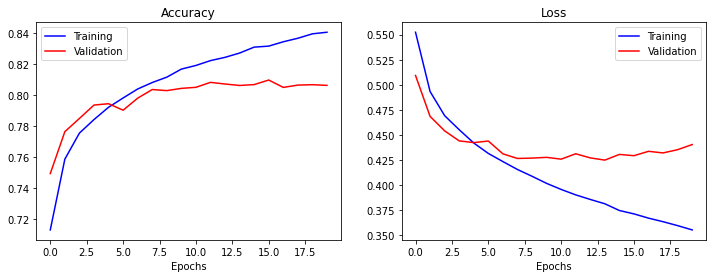

In [18]:
plot_history(history)